# Пространственная модель конкуренции типа Лотки-Вольтерра

Этот ноутбук демонстрирует механизм стабильного сосуществования двух видов в пространственной модели типа Лотки-Вольтерра. В отличие от конкурентного исключения, здесь оба вида достигают устойчивого равновесия благодаря особой структуре конкурентных взаимодействий.

## Ключевой механизм сосуществования

В основе модели лежит принцип, при котором **внутривидовая конкуренция превышает межвидовую**:

```python
competition_matrix = [
    0.02, 0.012,  # Внутривидовая > межвидовой
    0.012, 0.02   # Внутривидовая > межвидовой
]
```

## Пример из живой природы: луговые травы
Луговые травы с разными уровнями корневой системы формируют устойчивые смешанные сообщества. При увеличении плотности одного вида усиливается его внутривидовая конкуренция, что создает благоприятные условия для восстановления численности другого вида.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import sys
import os
from tqdm import tqdm
from scipy.stats import expon
from matplotlib import animation
from matplotlib.animation import FuncAnimation

Смотрим на то, где находится корень проекта.

In [3]:
os.getcwd()

'/home/michael/SBDPP_sim/examples'

Указываем корень проекта.

In [4]:
sys.path.append("/home/michael/SBDPP_sim") # ваш путь к папке с проектом
import simulation

In [5]:
L = 10.0       # Размер области
M = 2          # Количество видов
my_seed = 42   # seed для генератора случайных чисел

Генерируем палитру с фиксированными цветами для M видов и создаем словарь: {вид: цвет}

In [6]:
colors = sns.color_palette("tab10", M)
color_dict = {i: colors[i] for i in range(M)}

Инициализируем все параметры и устанавливаем виды в начальные позиции.

In [7]:
birth_rates = [0.33, 0.33]        # Вероятность рождаемости
natural_death_rates = [0.1, 0.1]  # Вероятность естественной смерти
competition_matrix = [            # Матрица конкуренции
    0.02, 0.012,                  # Влияние вида 1 на вид 1 и на вид 2
    0.012, 0.02                   # Влияние вида 2 на вид 1 и на вид 2
]                               

sigma_m = [1, 1]                  # Радиус распространения потомства

sigma_w = np.array([              # Радиус влияния конкуренции
    [0.4, 0.4],
    [0.4, 0.4],
])

def exponential_2d_radial(r, lambda_param):
    return (lambda_param**2) * r * np.exp(-lambda_param * r)

q_values = np.arange(0, 1.0, 0.001)
birth_inverse_values = []
for i in range(M):
    inverse_vals = np.sqrt(-2*np.log(1-q_values))/sigma_m[i]
    birth_inverse_values.append(inverse_vals.tolist())

death_r_values = []
death_density_values = []

for i in range(M):
    r_values_row = []
    density_row = []
    
    for j in range(M):
        r_max = min(5/sigma_w[i,j], L/2)
        r_vals = np.linspace(0, r_max, 500)
        
        density = exponential_2d_radial(r_vals, 1/sigma_w[i, j])
        
        r_values_row.append(r_vals.tolist())
        density_row.append(density.tolist())
    
    death_r_values.append(r_values_row)
    death_density_values.append(density_row)

max_sigma = max(max(sigma_m), np.max(sigma_w))
max_r = min(5/min(min(sigma_m), np.min(sigma_w[sigma_w > 0])), L/2)

g2 = simulation.PyGrid2(
    M = M,
    areaLen = [L, L],
    cellCount = [L, L],
    isPeriodic = False,
    birthRates = birth_rates,
    deathRates = natural_death_rates,
    ddMatrix = competition_matrix,
    birthX = [q_values.tolist()] * M,
    birthY = birth_inverse_values,
    deathX_ = death_r_values,
    deathY_ = death_density_values,
    cutoffs = [max_r] * (M * M),
    seed = my_seed,
    rtimeLimit = 7200.0
)

np.random.seed(my_seed)

coordinates = []
for _ in range(M):
    group = [[np.random.uniform(0, L), np.random.uniform(0, L)] for _ in range(400)]
    coordinates.append(group)

g2.placePopulation(coordinates)

Производим симуляцию.

In [8]:
data = []
for t in (pbar := tqdm(range(10000))):
    for c in range(g2.get_num_cells()):
        for n in range(M):
            coords = g2.get_cell_coords(c, n)
            for x, y in coords:
                data.append([t, x, y, n])
    g2.run_for(1)
    pbar.set_description(f"Population: {g2.total_population}, Progress")

df = pd.DataFrame(columns = ['time', 'x', 'y', 's'], data = data)
# display(df.set_index('time'))

Population: 211, Progress: 100%|██████████| 10000/10000 [00:34<00:00, 288.03it/s]


Выводим график первых моментов.

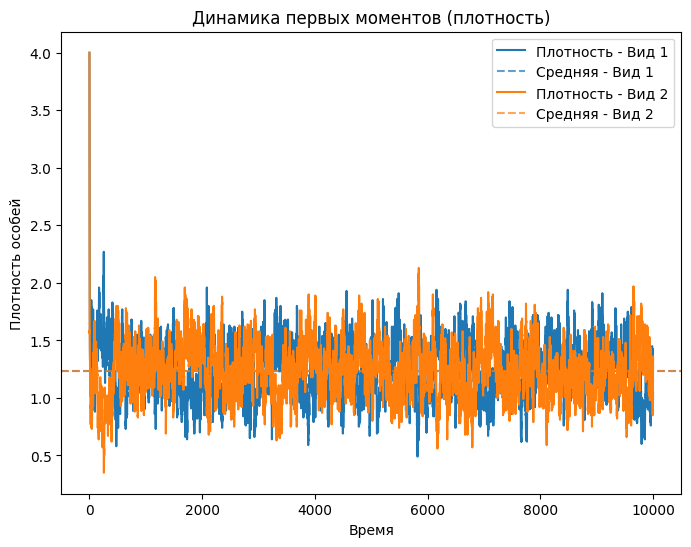

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))

for n in range(M):
    density = df[df['s'] == n].groupby('time').size() / (L ** 2)  
    median_density = density.median()

    ax.plot(density.index, density.values, label=f'Плотность - Вид {n+1}', color=color_dict[n])
    ax.axhline(median_density, linestyle="dashed", color=color_dict[n], alpha=0.7, label=f'Средняя - Вид {n+1}')

ax.legend()
ax.set_xlabel("Время")
ax.set_ylabel("Плотность особей")
ax.set_title("Динамика первых моментов (плотность)")

plt.show()

По полученным данным создаем видео.

In [ ]:
total_frames = df['time'].nunique()
desired_duration = 60
fps = total_frames / desired_duration

movie_writer = animation.FFMpegWriter(
    fps = fps,
    codec = 'h264',
    bitrate = 2000,
    extra_args = [
        '-vcodec', 'libx264',
        '-pix_fmt', 'yuv420p',
        '-preset', 'medium'
    ]
)

matplotlib.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg' # путь к ffmpeg

df = df.sort_values('time')
output_file = "Spatial_Exp_Coexistence_1min.mp4"

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(0, L)
ax.set_ylim(0, L)
ax.set_xlabel('x')
ax.set_ylabel('y')
sc = ax.scatter([], [], c=[], s=20, alpha=0.6)

def update(frame):
    current_df = df[df['time'] == frame]
    sc.set_offsets(current_df[['x', 'y']].values)
    sc.set_color([color_dict[s] for s in current_df['s']])
    ax.set_title(f"Time: {frame}")
    return sc,

ani = FuncAnimation(fig, update, frames=df['time'].nunique(), blit=True)
progress_callback = tqdm(total=total_frames, desc='Creating 1-minute video')

def on_frame(current_frame, *args):
    progress_callback.update(1)

ani.save(output_file, writer=movie_writer, progress_callback=on_frame)
progress_callback.close()

print(f"Animation saved as {output_file} (duration: 1 minute)")
plt.close(fig)

Creating 1-minute video:   2%|▏         | 155/10000 [00:23<08:10, 20.08it/s]